In [42]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

# load the dataset 
df = pd.read_csv("../data/Breast_cancer_dataset.csv")

# Drop useless columns
df = df.drop(columns=["id", "Unnamed: 32"], errors="ignore")

# Encode target
df["diagnosis"] = df["diagnosis"].map({"M": 1, "B": 0})

# Split features/target
X = df.drop("diagnosis", axis=1)
y = df["diagnosis"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Shapes ->", X_train.shape, X_test.shape, y_train.shape, y_test.shape)


Shapes -> (455, 30) (114, 30) (455,) (114,)


In [43]:
# Logistic Regression (Pipeline)

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_validate

log_reg_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=1000, random_state=42))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = ["accuracy", "precision", "recall", "f1", "roc_auc"]

cv_results = cross_validate(log_reg_pipe, X_train, y_train, cv=cv, scoring=scoring, return_train_score=False)

logreg_results = {m: np.mean(cv_results[f"test_{m}"]) for m in scoring}
pd.DataFrame([logreg_results], index=["Logistic Regression"])

,accuracy,precision,recall,f1,roc_auc
Logistic Regression,0.973626,0.977143,0.952941,0.964048,0.995769


In [44]:
# Random 
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=300, random_state=42)

cv_results = cross_validate(rf_clf, X_train, y_train, cv=cv, scoring = scoring, return_train_score=False)

rf_results = {m: np.mean(cv_results[f"test_{m}"]) for m in scoring}
pd.DataFrame([rf_results], index=["Random Forest"])

,accuracy,precision,recall,f1,roc_auc
Random Forest,0.96044,0.958381,0.935294,0.946148,0.987977


In [45]:
# Suppport Vector Machine
from sklearn.svm import SVC

svm_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", SVC(kernel="rbf", probability=True, random_state=42))
])

cv_results = cross_validate(svm_pipe, X_train, y_train, cv=cv, scoring=scoring, return_train_score=False)

svm_results = {m: np.mean(cv_results[f"test_{m}"]) for m in scoring}
pd.DataFrame([svm_results], index=["SVM (RBF)"])


,accuracy,precision,recall,f1,roc_auc
SVM (RBF),0.971429,0.976946,0.947059,0.960987,0.994943


In [46]:
# Gradient Boosting Model 
from sklearn.ensemble import HistGradientBoostingClassifier

gb_clf = HistGradientBoostingClassifier(random_state=42)

cv_results = cross_validate(gb_clf, X_train, y_train, cv=cv, scoring=scoring, return_train_score=False)

gb_results = {m: np.mean(cv_results[f"test_{m}"]) for m in scoring}
pd.DataFrame([gb_results], index=["Gradient Boosting"])


,accuracy,precision,recall,f1,roc_auc
Gradient Boosting,0.964835,0.964072,0.941176,0.951754,0.993292


In [47]:
#Neural Network 
from sklearn.neural_network import MLPClassifier

mlp_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", MLPClassifier(hidden_layer_sizes=(30,), max_iter=1000, random_state=42))
])

cv_results = cross_validate(mlp_pipe, X_train, y_train, cv=cv, scoring=scoring, return_train_score=False)

mlp_results = {m: np.mean(cv_results[f"test_{m}"]) for m in scoring}
pd.DataFrame([mlp_results], index=["Neural Net (MLP)"])


,accuracy,precision,recall,f1,roc_auc
Neural Net (MLP),0.98022,0.976925,0.970588,0.973296,0.994634


In [48]:
# DataFrame for comparison of all models
# Collect results 
all_results = [
    {"model": "Logistic Regression", **logreg_results},
    {"model": "Random Forest", **rf_results},
    {"model": "SVM (RBF)", **svm_results},
    {"model": "Gradient Boosting", **gb_results},
    {"model": "Neural Net (MLP)", **mlp_results},
]

results_df = pd.DataFrame(all_results).set_index("model")

# Order columns and round for display
metric_order = ["accuracy", "precision", "recall", "f1", "roc_auc"]
results_df = results_df[metric_order].round(4)

# Sort by your preferred metric for ranking (ROC-AUC or F1)
results_sorted = results_df.sort_values("roc_auc", ascending=False)

results_sorted

,accuracy,precision,recall,f1,roc_auc
model,,,,,
Logistic Regression,0.9736,0.9771,0.9529,0.9640,0.9958
SVM (RBF),0.9714,0.9769,0.9471,0.9610,0.9949
Neural Net (MLP),0.9802,0.9769,0.9706,0.9733,0.9946
Gradient Boosting,0.9648,0.9641,0.9412,0.9518,0.9933
Random Forest,0.9604,0.9584,0.9353,0.9461,0.9880


In [49]:
results_sorted.to_csv("../models/model_cv_results.csv")
print("Saved to ../models/model_cv_results.csv")

Saved to ../models/model_cv_results.csv


In [50]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score
import joblib
import os

# Pipeline: scale -> MLP
mlp_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", MLPClassifier(max_iter=1000, random_state=42, early_stopping=True))
])

# Hyperparameter grid (kept focused to finish quickly & avoid overfitting)
param_grid = {
    "clf__hidden_layer_sizes": [(30,), (50,), (64,32), (32,16)],
    "clf__activation": ["relu", "tanh"],
    "clf__alpha": [1e-5, 1e-4, 1e-3, 1e-2],          # L2 regularization
    "clf__learning_rate_init": [1e-3, 5e-3, 1e-2],   # step size
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {
    "accuracy": "accuracy",
    "precision": "precision",
    "recall": "recall",
    "f1": "f1",
    "roc_auc": "roc_auc",
}

grid = GridSearchCV(
    estimator=mlp_pipe,
    param_grid=param_grid,
    scoring=scoring,
    cv=cv,
    n_jobs=-1,
    refit="f1",              # pick the model with best F1
    return_train_score=False,
    verbose=0,
)

grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Best CV F1:", grid.best_score_)

# Nice summary table (top 10 rows by F1)
cvres = pd.DataFrame(grid.cv_results_)
cols = ["mean_test_accuracy","mean_test_precision","mean_test_recall","mean_test_f1","mean_test_roc_auc","params","rank_test_f1"]
display(cvres[cols].sort_values("mean_test_f1", ascending=False).head(10))

# --- Evaluate the best model on the held-out test set ---
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

# If model supports probabilities, compute ROC-AUC
if hasattr(best_model, "predict_proba"):
    y_scores = best_model.predict_proba(X_test)[:, 1]
    test_auc = roc_auc_score(y_test, y_scores)
else:
    test_auc = np.nan

print("\nClassification report on TEST set:\n")
print(classification_report(y_test, y_pred))
print("Test ROC-AUC:", test_auc)

# --- Save the best pipeline (includes scaler) ---
os.makedirs("../models", exist_ok=True)
joblib.dump(best_model, "../models/mlp_best_grid.joblib")
print("Saved best model to ../models/mlp_best_grid.joblib")


Best params: {'clf__activation': 'tanh', 'clf__alpha': 1e-05, 'clf__hidden_layer_sizes': (30,), 'clf__learning_rate_init': 0.01}
Best CV F1: 0.9511889077106469


,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1,mean_test_roc_auc,params,rank_test_f1
74,0.964835,0.982321,0.923529,0.951189,0.991641,"{'clf__activation': 'tanh', 'clf__alpha': 0.00...",1
50,0.964835,0.982321,0.923529,0.951189,0.991641,"{'clf__activation': 'tanh', 'clf__alpha': 1e-0...",1
86,0.964835,0.982321,0.923529,0.951189,0.991641,"{'clf__activation': 'tanh', 'clf__alpha': 0.01...",1
62,0.964835,0.982321,0.923529,0.951189,0.991641,"{'clf__activation': 'tanh', 'clf__alpha': 0.00...",1
77,0.962637,0.969675,0.929412,0.948882,0.992157,"{'clf__activation': 'tanh', 'clf__alpha': 0.00...",5
89,0.962637,0.969675,0.929412,0.948882,0.992157,"{'clf__activation': 'tanh', 'clf__alpha': 0.01...",5
53,0.962637,0.969675,0.929412,0.948882,0.992157,"{'clf__activation': 'tanh', 'clf__alpha': 1e-0...",5
65,0.962637,0.969675,0.929412,0.948882,0.992157,"{'clf__activation': 'tanh', 'clf__alpha': 0.00...",5
61,0.962637,0.982639,0.917647,0.947092,0.989267,"{'clf__activation': 'tanh', 'clf__alpha': 0.00...",9
49,0.962637,0.982639,0.917647,0.947092,0.989267,"{'clf__activation': 'tanh', 'clf__alpha': 1e-0...",9



Classification report on TEST set:

              precision    recall  f1-score   support

           0       0.96      0.97      0.97        72
           1       0.95      0.93      0.94        42

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114

Test ROC-AUC: 0.9957010582010583
Saved best model to ../models/mlp_best_grid.joblib


In [51]:
import json, pathlib
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

ART = pathlib.Path("../models"); ART.mkdir(exist_ok=True, parents=True)

# 1) Save your final CV comparison (you already built `results_sorted`)
results_sorted.to_csv(ART / "model_cv_results.csv", index=True)

# 2) Save best params from GridSearch
with open(ART / "mlp_best_params.json", "w") as f:
    json.dump(grid.best_params_, f, indent=2)

# 3) Save classification report on test set
from sklearn.metrics import classification_report
rep = classification_report(y_test, y_pred, output_dict=True)
with open(ART / "mlp_test_classification_report.json", "w") as f:
    json.dump(rep, f, indent=2)

print("Saved CV table, best params, and test report.")


Saved CV table, best params, and test report.


Saved confusion matrix and ROC curve images.


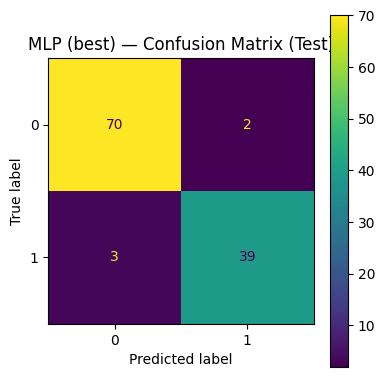

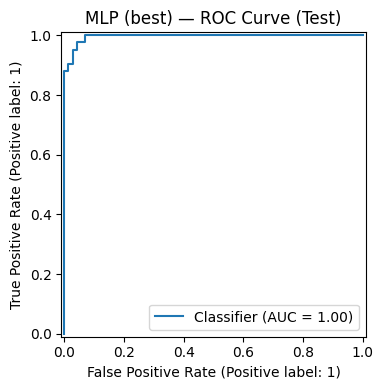

In [52]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay

# Confusion matrix
fig, ax = plt.subplots(figsize=(4,4))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax)
ax.set_title("MLP (best) — Confusion Matrix (Test)")
plt.tight_layout()
fig.savefig(ART / "mlp_confusion_matrix.png", dpi=150)

# ROC curve (we already computed y_scores; if not, recompute)
if hasattr(best_model, "predict_proba"):
    y_scores = best_model.predict_proba(X_test)[:, 1]
else:
    # fallback for models without predict_proba: decision_function if present
    y_scores = best_model.decision_function(X_test)

fig, ax = plt.subplots(figsize=(4,4))
RocCurveDisplay.from_predictions(y_test, y_scores, ax=ax)
ax.set_title("MLP (best) — ROC Curve (Test)")
plt.tight_layout()
fig.savefig(ART / "mlp_roc_curve.png", dpi=150)

print("Saved confusion matrix and ROC curve images.")


Saved permutation importance table + plot.


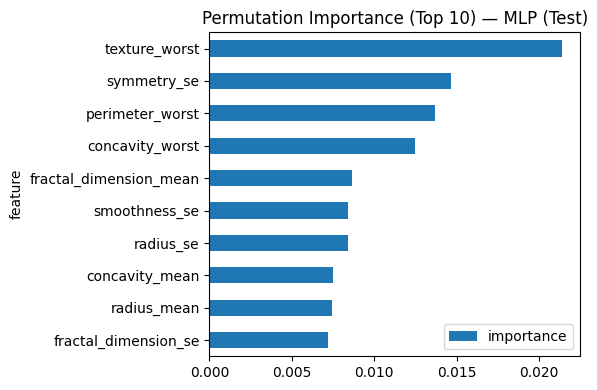

In [53]:

from sklearn.inspection import permutation_importance

# Use the pipeline safely: need the column names in correct order
feature_names = X_train.columns.tolist()
X_test_df = pd.DataFrame(X_test, columns=feature_names)

r = permutation_importance(best_model, X_test_df, y_test, n_repeats=20, random_state=42, scoring="f1")
imp = pd.DataFrame({"feature": feature_names, "importance": r.importances_mean}).sort_values("importance", ascending=False)

imp.head(10).to_csv(ART / "mlp_permutation_importance_top10.csv", index=False)

ax = imp.head(10).iloc[::-1].plot(kind="barh", x="feature", y="importance", figsize=(6,4))
ax.set_title("Permutation Importance (Top 10) — MLP (Test)")
plt.tight_layout()
plt.savefig(ART / "mlp_permutation_importance_top10.png", dpi=150)
print("Saved permutation importance table + plot.")


In [54]:
import numpy as np, json, pathlib
from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix

# Probabilities for the positive class
y_scores = (best_model.predict_proba(X_test)[:, 1]
            if hasattr(best_model, "predict_proba")
            else best_model.decision_function(X_test))

prec, rec, thr = precision_recall_curve(y_test, y_scores)

# Find the highest-precision threshold among those with recall >= 0.97
target_recall = 0.97
mask = rec[:-1] >= target_recall  # thr has length len(rec)-1
if mask.any():
    idx = np.argmax(prec[:-1][mask])
    best_idx = np.arange(len(thr))[mask][idx]
else:
    # fallback: choose threshold that maximizes F1 on PR curve
    f1 = 2 * (prec * rec) / (prec + rec + 1e-12)
    best_idx = np.argmax(f1[:-1])

best_threshold = float(thr[best_idx])
print("Chosen threshold:", best_threshold)

# Evaluate at this threshold
y_pred_thr = (y_scores >= best_threshold).astype(int)
print("\nClassification report @ chosen threshold:\n")
print(classification_report(y_test, y_pred_thr))

print("Confusion matrix @ threshold:\n", confusion_matrix(y_test, y_pred_thr))

# Save threshold for reuse
ART = pathlib.Path("../models"); ART.mkdir(exist_ok=True, parents=True)
with open(ART / "decision_threshold.json", "w") as f:
    json.dump({"threshold": best_threshold, "note": "Chosen for high recall on test set"}, f, indent=2)
print("Saved ../models/decision_threshold.json")


Chosen threshold: 0.3000042601904127

Classification report @ chosen threshold:

              precision    recall  f1-score   support

           0       0.99      0.96      0.97        72
           1       0.93      0.98      0.95        42

    accuracy                           0.96       114
   macro avg       0.96      0.97      0.96       114
weighted avg       0.97      0.96      0.97       114

Confusion matrix @ threshold:
 [[69  3]
 [ 1 41]]
Saved ../models/decision_threshold.json


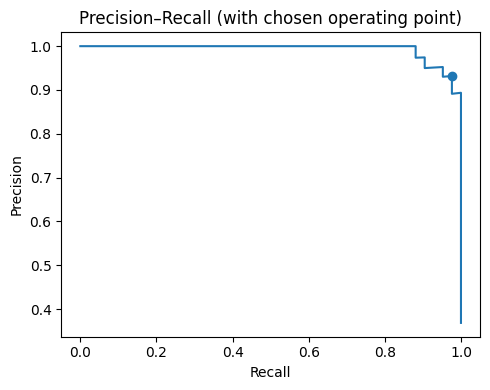

In [55]:
plt.figure(figsize=(5,4))
plt.plot(rec, prec)
plt.scatter(rec[best_idx], prec[best_idx])
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision–Recall (with chosen operating point)")
plt.tight_layout(); plt.show()


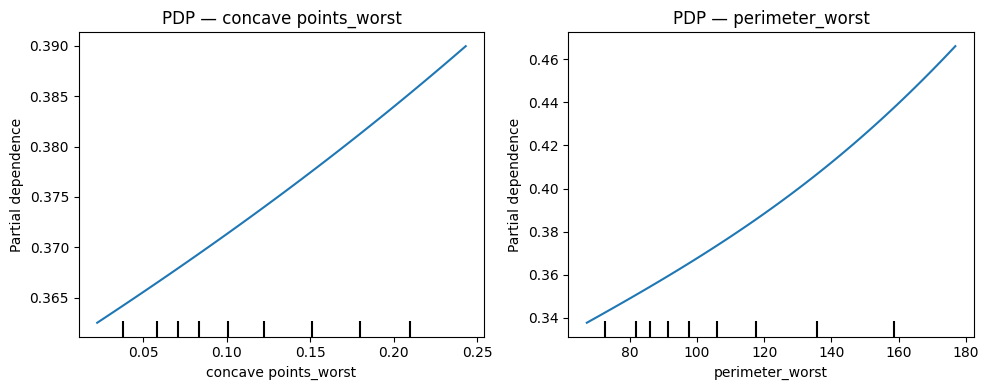

In [56]:
from sklearn.inspection import PartialDependenceDisplay

feature_names = X_train.columns.tolist()
X_train_df = pd.DataFrame(X_train, columns=feature_names)

fig, ax = plt.subplots(1, 2, figsize=(10,4))
PartialDependenceDisplay.from_estimator(best_model, X_train_df, ["concave points_worst"], ax=ax[0])
PartialDependenceDisplay.from_estimator(best_model, X_train_df, ["perimeter_worst"], ax=ax[1])
ax[0].set_title("PDP — concave points_worst")
ax[1].set_title("PDP — perimeter_worst")
plt.tight_layout(); plt.show()


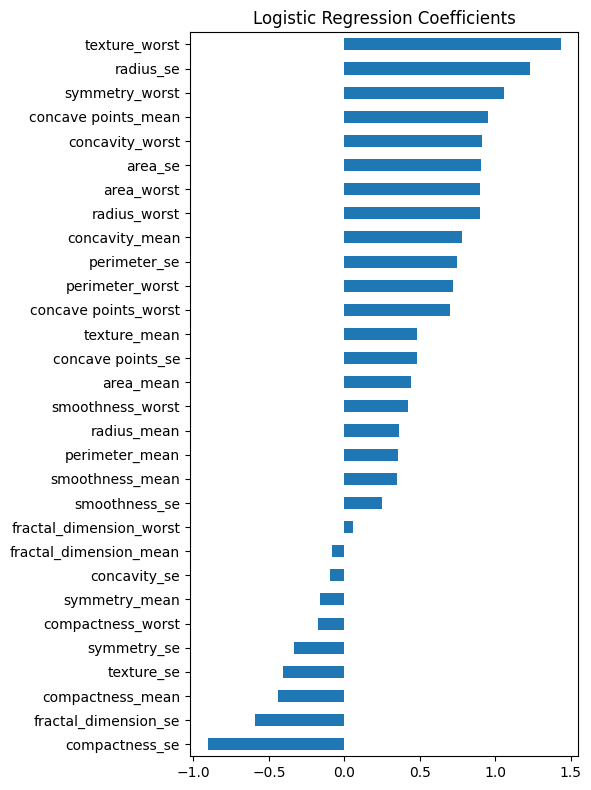

In [57]:
log_reg_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=1000, random_state=42))
]).fit(X_train, y_train)

coef = pd.Series(log_reg_pipe.named_steps["clf"].coef_.ravel(), index=X_train.columns)
coef.sort_values().plot(kind="barh", figsize=(6,8), title="Logistic Regression Coefficients")
plt.tight_layout(); plt.show()


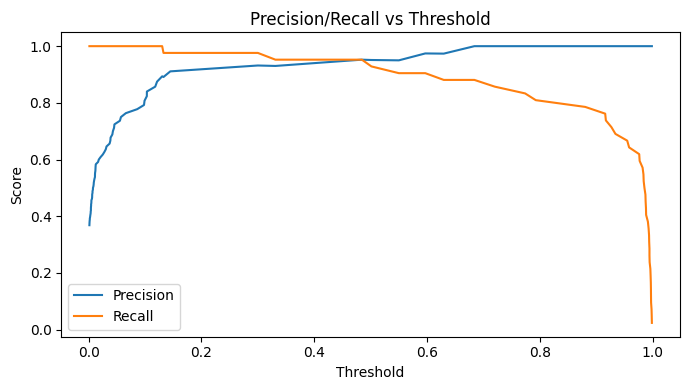

In [58]:


y_scores = best_model.predict_proba(X_test)[:, 1]
prec, rec, thr = precision_recall_curve(y_test, y_scores)

plt.figure(figsize=(7,4))
plt.plot(thr, prec[:-1], label="Precision")
plt.plot(thr, rec[:-1], label="Recall")
plt.xlabel("Threshold"); plt.ylabel("Score"); plt.title("Precision/Recall vs Threshold")
plt.legend(); plt.tight_layout(); plt.show()
